In [1]:
# IMDB Sentiment Classifier
# Author: ChatGPT
# Task: RNN/LSTM with GloVe and On-the-fly embeddings

import os, re, random, html
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [2]:
# Dataset and Embeddings
DATA_CSV = "IMDB Dataset.csv"   # keep the file in same folder
GLOVE_DIR = "./glove"
GLOVE_FILE = os.path.join(GLOVE_DIR, "glove.6B.100d.txt")

# Hyperparameters
GLOVE_DIM = 100
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 200
BATCH_SIZE = 64
NUM_EPOCHS = 6
LR = 1e-3
EMBEDDING_DROPOUT = 0.2
HIDDEN_SIZE = 128
NUM_LAYERS = 1

os.makedirs(GLOVE_DIR, exist_ok=True)


In [3]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"<.*?>", " ", text)          # remove HTML tags
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]+", " ", text)
    return text.lower().strip()

def tokenize(text):
    return text.split()


In [4]:
df = pd.read_csv(DATA_CSV)
print("Dataset shape:", df.shape)
print(df["sentiment"].value_counts())

df["review_clean"] = df["review"].apply(clean_text)
df["label"] = df["sentiment"].map({"negative":0, "positive":1})

# Split into train/val/test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df["label"])
print("train/val/test sizes:", len(train_df), len(val_df), len(test_df))


Dataset shape: (50000, 2)
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
train/val/test sizes: 36125 6375 7500


In [5]:
counter = Counter()
for txt in train_df["review_clean"]:
    counter.update(tokenize(txt))

most_common = counter.most_common(MAX_VOCAB_SIZE - 4)

PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"

itos = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + [w for w,_ in most_common]
stoi = {w:i for i,w in enumerate(itos)}
vocab_size = len(itos)
print("Vocab size:", vocab_size)

def encode_text(text, max_len=MAX_SEQ_LEN):
    tokens = tokenize(text)
    ids = [stoi.get(t, stoi[UNK_TOKEN]) for t in tokens]
    ids = ids[:max_len]
    return torch.tensor(ids, dtype=torch.long)


Vocab size: 20000


In [6]:
!mkdir -p glove
!wget -q http://nlp.stanford.edu/data/glove.6B.zip -O glove/glove.6B.zip
!unzip -q glove/glove.6B.zip -d glove


In [7]:
# Download manually if not present: https://nlp.stanford.edu/projects/glove/
assert os.path.exists(GLOVE_FILE), "Download glove.6B.100d.txt to ./glove/"

print("Loading GloVe vectors...")
emb_index = {}
with open(GLOVE_FILE, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split(" ")
        word, vec = parts[0], np.asarray(parts[1:], dtype="float32")
        emb_index[word] = vec
print("GloVe loaded:", len(emb_index))

embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, GLOVE_DIM)).astype(np.float32)
for i, word in enumerate(itos):
    if word in emb_index:
        embedding_matrix[i] = emb_index[word]

embedding_matrix = torch.tensor(embedding_matrix)


Loading GloVe vectors...
GloVe loaded: 400000


In [8]:
class IMDBDataset(Dataset):
    def __init__(self, df):
        self.texts = df["review_clean"].values
        self.labels = df["label"].values.astype(np.float32)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return encode_text(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=stoi[PAD_TOKEN])
    padded = padded[:, :MAX_SEQ_LEN]
    return padded, torch.tensor(labels)

train_loader = DataLoader(IMDBDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(IMDBDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(IMDBDataset(test_df),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [9]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, pretrained_embeddings=None, freeze=True):
        super().__init__()
        if pretrained_embeddings is not None:
            self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze, padding_idx=stoi[PAD_TOKEN])
        else:
            self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD_TOKEN])
        self.dropout = nn.Dropout(EMBEDDING_DROPOUT)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        emb = self.dropout(self.embed(x))
        _, h = self.rnn(emb)
        return self.fc(h[-1]).squeeze(1)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, pretrained_embeddings=None, freeze=True):
        super().__init__()
        if pretrained_embeddings is not None:
            self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze, padding_idx=stoi[PAD_TOKEN])
        else:
            self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD_TOKEN])
        self.dropout = nn.Dropout(EMBEDDING_DROPOUT)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        emb = self.dropout(self.embed(x))
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1]).squeeze(1)


In [10]:
criterion = nn.BCEWithLogitsLoss()

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        if is_train: optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if is_train:
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        y_pred.extend(torch.sigmoid(logits).detach().cpu().numpy())
        y_true.extend(y.cpu().numpy())
    acc = accuracy_score(y_true, [p>=0.5 for p in y_pred])
    auc = roc_auc_score(y_true, y_pred)
    return np.mean(losses), acc, auc

def train_model(name, model, train_loader, val_loader, epochs=NUM_EPOCHS):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    hist = {"val_auc":[]}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc = run_epoch(model, train_loader, opt)
        vl_loss, vl_acc, vl_auc = run_epoch(model, val_loader)
        hist["val_auc"].append(vl_auc)
        print(f"{name} | Epoch {ep}/{epochs} | Train AUC={tr_auc:.3f} | Val AUC={vl_auc:.3f}")
    return model, hist


In [11]:
results = {}

# 1. RNN + GloVe
rnn_glove, hist_rnn_glove = train_model("RNN-GloVe",
    RNNClassifier(vocab_size, GLOVE_DIM, HIDDEN_SIZE, pretrained_embeddings=embedding_matrix, freeze=True),
    train_loader, val_loader)
results["RNN-GloVe"] = (rnn_glove, hist_rnn_glove)

# 2. LSTM + GloVe
lstm_glove, hist_lstm_glove = train_model("LSTM-GloVe",
    LSTMClassifier(vocab_size, GLOVE_DIM, HIDDEN_SIZE, pretrained_embeddings=embedding_matrix, freeze=True),
    train_loader, val_loader)
results["LSTM-GloVe"] = (lstm_glove, hist_lstm_glove)

# 3. RNN + On-the-fly
rnn_otf, hist_rnn_otf = train_model("RNN-OtF",
    RNNClassifier(vocab_size, GLOVE_DIM, HIDDEN_SIZE, pretrained_embeddings=None, freeze=False),
    train_loader, val_loader)
results["RNN-OtF"] = (rnn_otf, hist_rnn_otf)

# 4. LSTM + On-the-fly
lstm_otf, hist_lstm_otf = train_model("LSTM-OtF",
    LSTMClassifier(vocab_size, GLOVE_DIM, HIDDEN_SIZE, pretrained_embeddings=None, freeze=False),
    train_loader, val_loader)
results["LSTM-OtF"] = (lstm_otf, hist_lstm_otf)


RNN-GloVe | Epoch 1/6 | Train AUC=0.512 | Val AUC=0.519
RNN-GloVe | Epoch 2/6 | Train AUC=0.527 | Val AUC=0.530
RNN-GloVe | Epoch 3/6 | Train AUC=0.526 | Val AUC=0.514
RNN-GloVe | Epoch 4/6 | Train AUC=0.515 | Val AUC=0.525
RNN-GloVe | Epoch 5/6 | Train AUC=0.514 | Val AUC=0.522
RNN-GloVe | Epoch 6/6 | Train AUC=0.516 | Val AUC=0.523
LSTM-GloVe | Epoch 1/6 | Train AUC=0.535 | Val AUC=0.521
LSTM-GloVe | Epoch 2/6 | Train AUC=0.528 | Val AUC=0.518
LSTM-GloVe | Epoch 3/6 | Train AUC=0.528 | Val AUC=0.577
LSTM-GloVe | Epoch 4/6 | Train AUC=0.634 | Val AUC=0.777
LSTM-GloVe | Epoch 5/6 | Train AUC=0.796 | Val AUC=0.872
LSTM-GloVe | Epoch 6/6 | Train AUC=0.869 | Val AUC=0.897
RNN-OtF | Epoch 1/6 | Train AUC=0.506 | Val AUC=0.511
RNN-OtF | Epoch 2/6 | Train AUC=0.524 | Val AUC=0.509
RNN-OtF | Epoch 3/6 | Train AUC=0.509 | Val AUC=0.514
RNN-OtF | Epoch 4/6 | Train AUC=0.513 | Val AUC=0.503
RNN-OtF | Epoch 5/6 | Train AUC=0.520 | Val AUC=0.513
RNN-OtF | Epoch 6/6 | Train AUC=0.541 | Val AUC=0.50

RNN-GloVe: Test Acc=0.513, AUC=0.525
LSTM-GloVe: Test Acc=0.819, AUC=0.900
RNN-OtF: Test Acc=0.507, AUC=0.518
LSTM-OtF: Test Acc=0.813, AUC=0.885


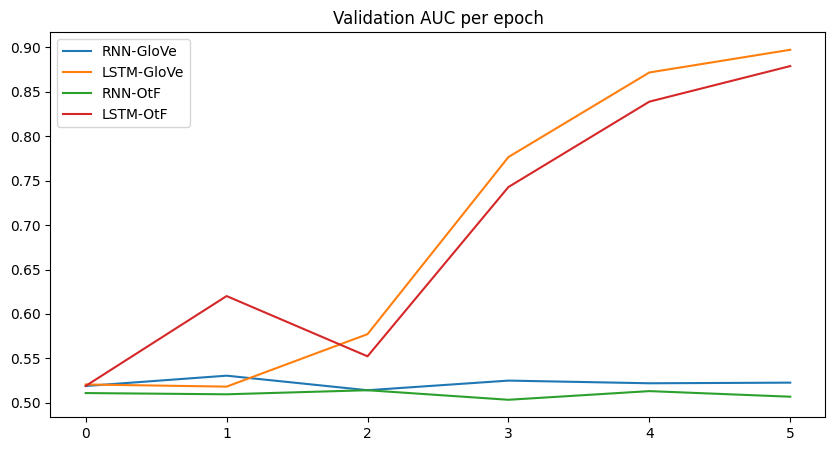

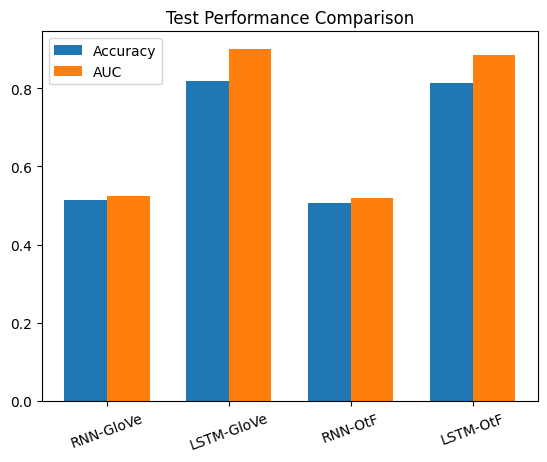

In [12]:
summary = {}
for name, (model, hist) in results.items():
    loss, acc, auc = run_epoch(model, test_loader)
    summary[name] = {"test_acc": acc, "test_auc": auc, "hist": hist}
    print(f"{name}: Test Acc={acc:.3f}, AUC={auc:.3f}")

# Plot Validation AUC curves
plt.figure(figsize=(10,5))
for name, info in summary.items():
    plt.plot(info["hist"]["val_auc"], label=name)
plt.legend(); plt.title("Validation AUC per epoch"); plt.show()

# Final comparison bar chart
names = list(summary.keys())
accs = [summary[n]["test_acc"] for n in names]
aucs = [summary[n]["test_auc"] for n in names]

x = np.arange(len(names)); w = 0.35
plt.bar(x-w/2, accs, w, label="Accuracy")
plt.bar(x+w/2, aucs, w, label="AUC")
plt.xticks(x, names, rotation=20); plt.legend()
plt.title("Test Performance Comparison")
plt.show()
